In [ ]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Spoiler Detection/spoiler-detection/bert"
%ls

/content/drive/MyDrive/Spoiler Detection/spoiler-detection/bert
Autolabel.ipynb           eda.ipynb                          recall.gz
bbc-text.csv              goodreads_reviews_spoiler.json     thresholds.gz
checkpoints/              goodreads_reviews_spoiler.json.gz  train.ipynb
dataset_1000_aot-s4.json  precision.gz
dataset.py                __pycache__/


In [ ]:
import gzip
import json
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

def flatten(path):
    g = gzip.open(path, 'r')
    for l in g:
        d = json.loads(l)
        for s in d['review_sentences']:
            yield s

In [ ]:
# data = list(parse('goodreads_reviews_spoiler.json.gz'))
import numpy as np
import time

t0 = time.time()
data = list(flatten('goodreads_reviews_spoiler.json.gz'))
t1 = time.time()

t1-t0

67.51038146018982

In [ ]:
from collections import Counter
c = Counter([d[0] for d in data])

In [ ]:
c[1] / len(data)

0.03223760097167064

In [ ]:
len(data)

17672655

In [ ]:
from transformers import RobertaTokenizerFast
from tqdm import tqdm
from joblib import Parallel, delayed
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

def get_flattened(raw_data):
    for d in raw_data:
        for s in d['review_sentences']:
            yield s

def get_num_tokens(sent):
    return len(tokenizer(sent[1])['input_ids'])

num_tokens = Parallel(n_jobs=-1, verbose=1, prefer='threads')(delayed(get_num_tokens)(d) for d in get_flattened(data))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 11246 tasks  

In [ ]:
num_tokens.sort(reverse=True)

In [ ]:
# Truncate at 200 tokens
num_tokens[:30]

[10537,
 988,
 311,
 304,
 289,
 277,
 264,
 262,
 262,
 261,
 256,
 252,
 249,
 240,
 240,
 237,
 235,
 227,
 225,
 223,
 219,
 217,
 213,
 207,
 207,
 207,
 207,
 202,
 201,
 198]

In [ ]:
import numpy as np
np.min(num_tokens), np.median(num_tokens), np.mean(num_tokens), np.std(num_tokens), np.max(num_tokens)

(3, 15.0, 18.12385697584891, 13.444451765611172, 6911)

In [ ]:
top1_removed = num_tokens[:1080522] + num_tokens[1080523:]
np.argmax(top1_removed)

448693

In [ ]:
top2_removed = top1_removed[:448693] + top1_removed[448694:]

In [ ]:
np.max(top1_removed)

361

In [ ]:
len(num_tokens)

17672655

(array([54., 14.,  1.,  0.,  2.,  0.,  0.]),
 array([150, 200, 250, 300, 350, 400, 450, 500]),
 <a list of 7 Patch objects>)

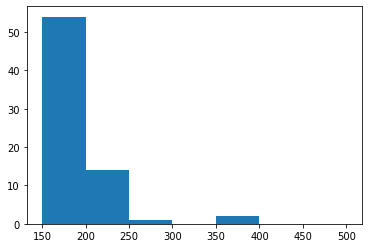

In [ ]:
import matplotlib.pyplot as plt
plt.hist(num_tokens, bins=[150, 200, 250, 300, 350, 400, 450, 500])

In [ ]:
import numpy as np
from transformers import BertTokenizer
import pytorch_lightning as pl
import torch
import pandas as pd
import os
import gzip
import pickle

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class GoodreadsFlattenedDataset(torch.utils.data.Dataset):

    def __init__(self, df, max_length=512):
        print('max_length: {}'.format(max_length))
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = max_length, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


class GoodreadsFlattenedModule(pl.LightningDataModule):
    def __init__(self, data_file: str = "goodreads_reviews_spoiler.json.gz", batch_size: int = 16, num_workers=8, seed=42):
        super().__init__()
        self.data_file = data_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.rand_seed = seed

    def setup(self, stage=None):
        cached_file = 'goodreads_reviews_spoiler_flattened.gz'
        if os.path.isfile(cached_file):
            with gzip.open(cached_file, 'rb') as f:
                data = pickle.load(f)
        else:
            from joblib import Parallel, delayed
            def get_num_tokens(d):
                for s in d['review_sentences']:
                    return [s[0], tokenizer(s[1])]
            test = Parallel(n_jobs=-1, verbose=10, prefer='threads')(delayed(get_num_tokens)(d) for d in data)
            

        df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=self.rand_seed), 
                                            [int(.8*len(df)), int(.9*len(df))])
        self.trainset = BBCDataset(df_train)
        self.valset = BBCDataset(df_val)
        self.testset = BBCDataset(df_test)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.trainset, 
                                           batch_size=self.batch_size, 
                                           shuffle=True,
                                           num_workers=self.num_workers)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valset, 
                                           batch_size=self.batch_size, 
                                           shuffle=False,
                                           num_workers=self.num_workers)
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.testset, 
                                           batch_size=self.batch_size, 
                                           shuffle=False,
                                           num_workers=self.num_workers)

In [7]:
import json
with open('dataset_1000_aot-s4.json', 'r') as f:
    messages = json.load(f)
data = [(0 if 'Non-spoiler' in m['label'] else 1, m['data']) for m in messages]

In [10]:
spoilers_by_len = [d for d in data if d[0] == 1]
spoilers_by_len.sort(key=lambda d: len(d[1]))

In [11]:
spoilers_by_len

[(1, 'the rumbling'),
 (1, 'Bye bye levi'),
 (1, 'Thunder spear'),
 (1, 'gabi sniper ez'),
 (1, 'Delicious wine'),
 (1, 'headless moment'),
 (1, 'Thicc war hammer'),
 (1, 'Next to beast titan'),
 (1, 'I only see Barbeque'),
 (1, 'saddest death? willy'),
 (1, "mikasa ate armin's d-"),
 (1, "There's a war going on"),
 (1, 'When his head is totally'),
 (1, 'Wait so nobody died today?'),
 (1, 'got monkey fall in this ep'),
 (1, 'Eren went full JJK on Armin'),
 (1, 'Me waiting for the rumbling:'),
 (1, 'You can see gabi in the mouth'),
 (1, 'Thats erwin in his titan form'),
 (1, 'Ymir was the weakest jaw titan'),
 (1, 'big monkey zeke dont shout plz'),
 (1, 'Armin is smart so he fights him'),
 (1, 'titans are used in wars i think'),
 (1, 'Guys, why goth mikasa was shown?'),
 (1, 'RIP meat lover:SNOsashasmug: \U0001f972 😭'),
 (1, 'Ofc they would cut in willy death'),
 (1, 'Except ereh told her he hated her'),
 (1, 'i forgot the cart titan could speak'),
 (1, "WHo's gAbi gonna shot idk well s

In [12]:
len(spoilers_by_len[0][1])

12

In [13]:
[m['data'] for m in messages if 'Trolling' in m['label']]

['i liked when mikasa argued with armin about what bread to buy',
 'Thats erwin in his titan form',
 'its Joe titan',
 "mikasa ate armin's d-"]

In [14]:
[m['data'] for m in messages if 'Speculation' in m['label']]

['Maybe the ending will be the rumbling starting',
 "||I can't believe eren dies at the end||",
 'After a scene from the rumbling, they show an image of the person, it’s a case of if you know you know',
 'Manga Spoilers\n|| I want to see the fight with ancient titans asap ||']